# Part 1: Alternating Least Squares for Matrix Factorization

The notebook in [part 0]() introduced a popular matrix factorization technique, Singular Value Decomposition (*SVD*) and showed its usefulness. This notebook will describe how matrix factorization can be used to build a recommender system via the Alternating Least Squares (*ALS*) algorithm.

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import PIL
import random
import os
import sklearn.metrics

random.seed(0)
np.random.seed(0)

In [2]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
dataset = pd.read_csv('datasets/ml-100k/u.data', sep='\t', names=names)
del dataset['timestamp']
dataset.head()

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [3]:
def build_ratings_matrix(dataset):
    num_users = dataset['user_id'].unique().shape[0]
    num_items = dataset['item_id'].unique().shape[0]

    ratings_mat = np.zeros((num_users, num_items))
    
    for idx, row in dataset.iterrows():
        ratings_mat[row['user_id']-1, row['item_id']-1] = row['rating']
    
    return ratings_mat

ratings = build_ratings_matrix(dataset)

In [4]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        rated_items = ratings[user, :].nonzero()[0] 
        test_ratings = np.random.choice(rated_items, 
                                        size=3, 
                                        replace=False)
        
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    return train, test

train_set, test_set = train_test_split(ratings)

In [5]:
def als_step(latent_vectors, fixed_vectors, ratings, regularization_param, step_type):
    denom_first = fixed_vectors.T.dot(fixed_vectors)
    denom_second = np.eye(denom_first.shape[0]) * regularization_param       
    
    if step_type == 'user':
        for i in range(0, latent_vectors.shape[0], 1):
            latent_vectors[i, :] = np.linalg.solve(denom_first + denom_second, ratings[i, :].dot(fixed_vectors))
    elif step_type == 'item':
        for i in range(0, latent_vectors.shape[0], 1):
            latent_vectors[i, :] = np.linalg.solve(denom_first + denom_second, ratings[:, i].dot(fixed_vectors))
            
    return latent_vectors

def training_step(user_vec, item_vec, ratings, regularization_user, regularization_item):
    user_vec = als_step(user_vec, item_vec, ratings, regularization_user, 'user')
    item_vec = als_step(item_vec, user_vec, ratings, regularization_item, 'item')
    return (user_vec, item_vec)

In [6]:
def predict_one(user_vec, item_vec, user_idx, item_idx):
    return user_vec[user_idx, :].dot(item_vec[item_idx, :])
    
def predict_all(user_vec, item_vec):
    predictions = np.zeros((num_users, num_items))
    
    for u in range(0, num_users, 1):
        for b in range(0, num_items, 1):
            predictions[u, b] = predict_one(user_vec, item_vec, u, b) 
    
    return predictions

In [7]:
def compute_mae(predicted, actual):
    labeled_elements = actual.nonzero()
    predicted = predicted[labeled_elements].flatten()
    actual = actual[labeled_elements].flatten()
    return sklearn.metrics.mean_absolute_error(actual, predicted)

In [8]:
num_factors = 10
num_users = dataset['user_id'].unique().shape[0]
num_items = dataset['item_id'].unique().shape[0]
l1_reg_items = 0.1
l1_reg_users = 0.1

user_vectors = np.random.random((num_users, num_factors))
item_vectors = np.random.random((num_items, num_factors))

history = []
for train_idx in range(0, 50, 1):
    old_user_vectors = user_vectors.copy()
    old_item_vectors = item_vectors.copy()
    user_vectors, item_vectors = training_step(user_vectors, item_vectors, ratings, l1_reg_items, l1_reg_users)
    
    this_history = {}
    all_predictions = predict_all(user_vectors, item_vectors)
    this_history['train_mse'] = compute_mae(all_predictions, train_set)
    this_history['test_mse'] = compute_mae(all_predictions, test_set)
    this_history['diff_users'] = np.sum(np.sum(np.abs(old_user_vectors - user_vectors)))
    this_history['diff_items'] = np.sum(np.sum(np.abs(old_item_vectors - item_vectors)))
    
    history.append(this_history)

    print('Completed training iteration {0}'.format(train_idx + 1))

print('Done!')

Completed training iteration 1
Completed training iteration 2
Completed training iteration 3
Completed training iteration 4
Completed training iteration 5
Completed training iteration 6
Completed training iteration 7
Completed training iteration 8
Completed training iteration 9
Completed training iteration 10
Completed training iteration 11
Completed training iteration 12
Completed training iteration 13
Completed training iteration 14
Completed training iteration 15
Completed training iteration 16
Completed training iteration 17
Completed training iteration 18
Completed training iteration 19
Completed training iteration 20
Completed training iteration 21
Completed training iteration 22
Completed training iteration 23
Completed training iteration 24
Completed training iteration 25
Completed training iteration 26
Completed training iteration 27
Completed training iteration 28
Completed training iteration 29
Completed training iteration 30
Completed training iteration 31
Completed trainin

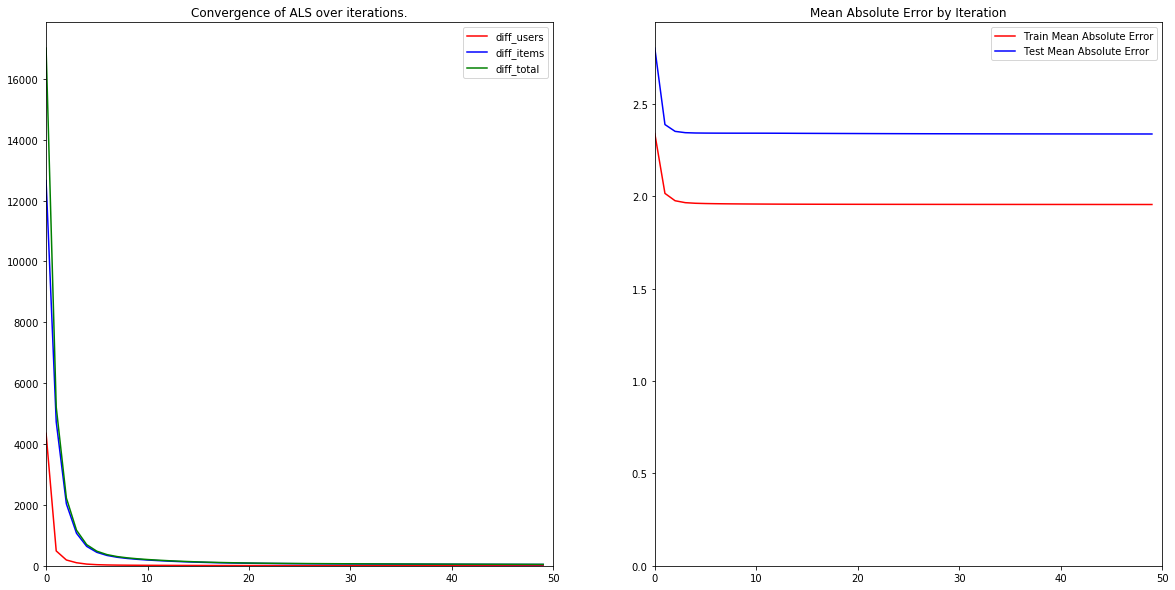

In [10]:
diff_user_vec = [h['diff_users'] for h in history]
diff_items_vec = [h['diff_items'] for h in history]
diff_total_vec = [h['diff_users'] + h['diff_items'] for h in history]
train_mse_vec = [h['train_mse'] for h in history]
test_mse_vec = [h['test_mse'] for h in history]
x_axis = list(range(0, len(history), 1))

fig, (ax_left, ax_right) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

ax_left.plot(x_axis, diff_user_vec, 'r-', label='diff_users')
ax_left.plot(x_axis, diff_items_vec, 'b-', label='diff_items')
ax_left.plot(x_axis, diff_total_vec, 'g-', label='diff_total')
ax_left.set_title('Convergence of ALS over iterations.')
ax_left.set_xlim(0, max(x_axis) + 1)
ax_left.set_ylim(0, max(diff_total_vec) * 1.05)
ax_left.legend()

ax_right.plot(x_axis, train_mse_vec, 'r-', label='Train Mean Absolute Error')
ax_right.plot(x_axis, test_mse_vec, 'b-', label='Test Mean Absolute Error')
ax_right.set_title('Mean Absolute Error by Iteration')
ax_right.set_xlim(0, max(x_axis) + 1)
ax_right.set_ylim(0, max(test_mse_vec) * 1.05)
ax_right.legend()

plt.show()